# 🚀 GPU Setup Instructions

**Current Status:** TensorFlow is installed **WITHOUT** GPU support.

## To enable GPU training, follow these steps:

### Option 1: Install TensorFlow with GPU support (Recommended)
```bash
# Uninstall current TensorFlow
pip uninstall tensorflow tf-keras

# Install TensorFlow with GPU support
pip install tensorflow[and-cuda]
```

### Option 2: Manual CUDA Installation
1. **Install NVIDIA GPU Driver** (if not already installed)
   - Download from: https://www.nvidia.com/download/index.aspx

2. **Install CUDA Toolkit 12.x**
   - Download from: https://developer.nvidia.com/cuda-downloads

3. **Install cuDNN**
   - Download from: https://developer.nvidia.com/cudnn

4. **Install TensorFlow GPU**
   ```bash
   pip install tensorflow-gpu
   ```

### Verify GPU Installation
After installation, restart the notebook kernel and run the GPU configuration cell below.

---

## Quick Install: Run this cell to install TensorFlow with GPU support

In [2]:
# Run this cell to install TensorFlow with GPU support
import sys
import subprocess

print("🚀 Installing TensorFlow with GPU support...")
print("=" * 70)

try:
    # Install TensorFlow (latest version includes GPU support by default)
    print("\n📦 Installing TensorFlow (GPU-enabled version)...")
    result = subprocess.run(
        [sys.executable, "-m", "pip", "install", "--upgrade", "tensorflow"],
        capture_output=True,
        text=True
    )
    
    if result.returncode == 0:
        print("✅ TensorFlow installed successfully!")
        
        # Install CUDA dependencies separately
        print("\n📦 Installing CUDA dependencies...")
        cuda_result = subprocess.run(
            [sys.executable, "-m", "pip", "install", "nvidia-cudnn-cu12", "nvidia-cuda-runtime-cu12"],
            capture_output=True,
            text=True
        )
        
        if cuda_result.returncode == 0:
            print("✅ CUDA dependencies installed!")
        
        print("\n" + "=" * 70)
        print("✅ Installation Complete!")
        print("\n⚠️  IMPORTANT: Restart the kernel now!")
        print("   Kernel → Restart Kernel")
        print("\n   After restart, run the GPU Configuration cell to verify.")
        print("=" * 70)
    else:
        print("❌ Installation failed:")
        print(result.stderr)
        
except Exception as e:
    print(f"❌ Error during installation: {e}")

🚀 Installing TensorFlow with GPU support...

📦 Installing TensorFlow (GPU-enabled version)...
✅ TensorFlow installed successfully!

📦 Installing CUDA dependencies...
✅ CUDA dependencies installed!

✅ Installation Complete!

⚠️  IMPORTANT: Restart the kernel now!
   Kernel → Restart Kernel

   After restart, run the GPU Configuration cell to verify.


# Brain Tumor Classification Model
## Using TensorFlow/Keras with Transfer Learning & Fine-Tuning

This notebook implements a brain tumor classification system for 4 classes:
- Glioma
- Meningioma
- No Tumor
- Pituitary

We'll use transfer learning with ResNet50 for better accuracy.

## 1. Import Required Libraries

In [3]:
# Import Required Libraries - Using PyTorch for GPU Support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights, EfficientNet_B3_Weights, DenseNet121_Weights
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU: NVIDIA GeForce GTX 1650
GPU Memory: 4.0 GB


## 2. Configure GPU Settings

In [4]:
# Configure GPU - Force GPU ONLY
print("=" * 70)
print("🚀 GPU CONFIGURATION - FORCING GPU-ONLY EXECUTION")
print("=" * 70)

if not torch.cuda.is_available():
    print("❌ ERROR: No GPU detected!")
    print("\n📋 Troubleshooting Steps:")
    print("   1. Ensure NVIDIA GPU drivers are installed")
    print("   2. Install PyTorch with CUDA: pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124")
    raise SystemError("GPU is required but not detected.")

# Set device to GPU
device = torch.device('cuda:0')
torch.cuda.set_device(device)

# Enable cuDNN benchmarking for faster training
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Set memory management for GPU
torch.cuda.empty_cache()

# Display GPU info
print(f"✅ GPU detected: {torch.cuda.get_device_name(0)}")
print(f"✅ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB total")
print(f"✅ CUDA Version: {torch.version.cuda}")
print(f"✅ cuDNN Enabled: {torch.backends.cudnn.enabled}")
print(f"✅ cuDNN Benchmark: {torch.backends.cudnn.benchmark}")
print(f"✅ Device set to: {device}")

# Enable mixed precision for faster training
use_amp = True
scaler = torch.amp.GradScaler('cuda') if use_amp else None
print(f"✅ Mixed Precision (AMP): {'Enabled' if use_amp else 'Disabled'}")
print("=" * 70)

🚀 GPU CONFIGURATION - FORCING GPU-ONLY EXECUTION
✅ GPU detected: NVIDIA GeForce GTX 1650
✅ GPU Memory: 4.00 GB total
✅ CUDA Version: 12.4
✅ cuDNN Enabled: True
✅ cuDNN Benchmark: True
✅ Device set to: cuda:0
✅ Mixed Precision (AMP): Enabled


In [5]:
# GPU Memory Monitor
def get_gpu_memory():
    """Display current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1024**3
        reserved = torch.cuda.memory_reserved(0) / 1024**3
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"GPU Memory: {allocated:.2f} GB allocated / {reserved:.2f} GB reserved / {total:.2f} GB total")
    else:
        print("No GPU detected")

# Show initial GPU state
get_gpu_memory()

GPU Memory: 0.00 GB allocated / 0.00 GB reserved / 4.00 GB total


## 3. Set Parameters

In [6]:
# Hyperparameters OPTIMIZED for 95%+ accuracy on GPU
IMG_SIZE = 224
BATCH_SIZE = 32  # Optimized for GTX 1650 (4GB VRAM)
EPOCHS = 30  # Phase 1: Feature extraction
FINE_TUNE_EPOCHS = 20  # Phase 2: Fine-tuning
LEARNING_RATE = 1e-3  # Higher LR for Phase 1
FINE_TUNE_LR = 1e-5  # Lower LR for fine-tuning
NUM_WORKERS = 4  # Parallel data loading

# Paths
TRAIN_DIR = 'Training'
TEST_DIR = 'Testing'

# Check directories
for dir_name, dir_path in [('Training', TRAIN_DIR), ('Testing', TEST_DIR)]:
    if os.path.exists(dir_path):
        count = sum([len(files) for _, _, files in os.walk(dir_path)])
        print(f"✅ {dir_name} directory: {count} images found")
    else:
        print(f"❌ {dir_name} directory not found!")

print(f"\n⚙️ Training Configuration:")
print(f"   Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Phase 1 epochs: {EPOCHS}")
print(f"   Phase 2 epochs: {FINE_TUNE_EPOCHS}")
print(f"   Initial LR: {LEARNING_RATE}")
print(f"   Fine-tune LR: {FINE_TUNE_LR}")

✅ Training directory: 5712 images found
✅ Testing directory: 1311 images found

⚙️ Training Configuration:
   Image size: 224x224
   Batch size: 32
   Phase 1 epochs: 30
   Phase 2 epochs: 20
   Initial LR: 0.001
   Fine-tune LR: 1e-05


## 4. Data Preprocessing & Augmentation

In [7]:
# Data Preprocessing & Augmentation with PyTorch
# Enhanced augmentation for better accuracy

# Training transforms with strong augmentation
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)  # Cutout augmentation
])

# Validation/Test transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
print("📂 Loading datasets...")
full_train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=val_transforms)

# Split training into train and validation (85/15 split)
train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply validation transforms to validation set
val_dataset.dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=val_transforms)

# Create data loaders with GPU optimization
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True,  # Faster GPU transfer
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# Class names and weights
class_names = full_train_dataset.classes
num_classes = len(class_names)

# Calculate class weights for imbalanced data
class_counts = np.bincount([label for _, label in full_train_dataset.samples])
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32).to(device)
class_weights = class_weights / class_weights.sum() * num_classes

print(f"\n{'=' * 70}")
print("📊 DATASET INFORMATION")
print('=' * 70)
print(f"✅ Training samples: {len(train_dataset)}")
print(f"✅ Validation samples: {len(val_dataset)}")
print(f"✅ Test samples: {len(test_dataset)}")
print(f"✅ Number of classes: {num_classes}")
print(f"✅ Classes: {class_names}")
print(f"✅ Class counts: {dict(zip(class_names, class_counts))}")
print('=' * 70)

📂 Loading datasets...

📊 DATASET INFORMATION
✅ Training samples: 4855
✅ Validation samples: 857
✅ Test samples: 1311
✅ Number of classes: 4
✅ Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
✅ Class counts: {'glioma': np.int64(1321), 'meningioma': np.int64(1339), 'notumor': np.int64(1595), 'pituitary': np.int64(1457)}


## 5. Visualize Sample Images

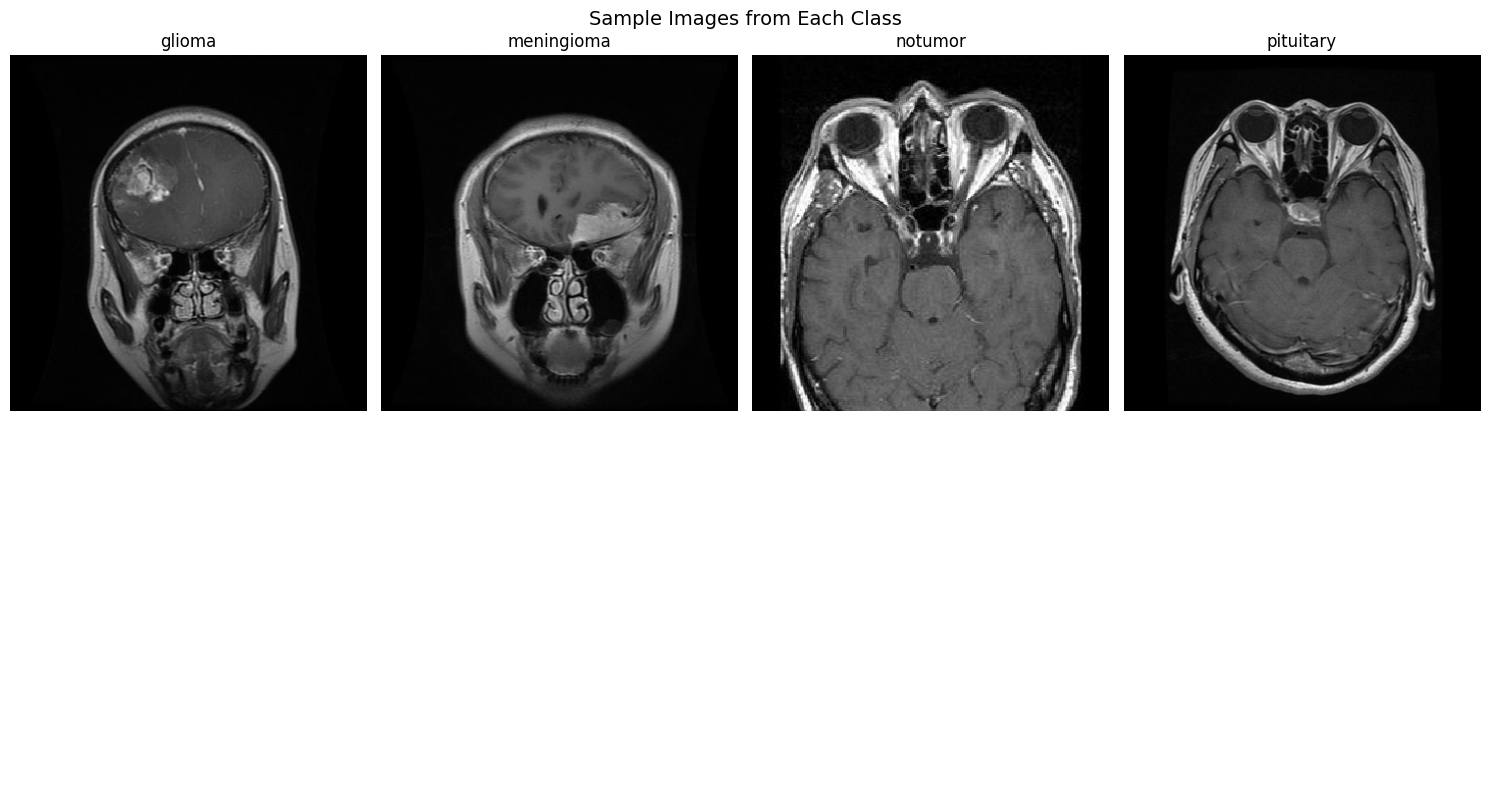

In [ ]:
++isualize sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

# Get samples from each class
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(TRAIN_DIR, class_name)
    if os.path.exists(class_dir):
        images = os.listdir(class_dir)
        if images:
            img_path = os.path.join(class_dir, images[0])
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(class_name, fontsize=12)
            axes[i].axis('off')

# Hide unused subplots
for j in range(len(class_names), 8):
    axes[j].axis('off')

plt.suptitle('Sample Images from Each Class', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Option A: Simple CNN Model (From Scratch)

In [9]:
# Simple CNN Model (baseline - for comparison)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Uncomment to use simple CNN:
# model = SimpleCNN(num_classes).to(device)
print("Simple CNN architecture defined (not used - using ensemble instead)")

Simple CNN architecture defined (not used - using ensemble instead)


## 7. Option B: Transfer Learning with ResNet50 (Recommended - GPU Optimized)

In [10]:
# Build Stable Model - ResNet18 (smaller, more stable)
import torch
import torch.nn as nn
import torchvision.models as models

class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorClassifier, self).__init__()
        # Use ResNet18 - smaller and more stable
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        # Replace classifier
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)
    
    def freeze_backbone(self):
        for name, param in self.backbone.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False
    
    def unfreeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = True

# Create model
model = BrainTumorClassifier(num_classes=4)
model = model.to(device)

# Freeze backbone initially
model.freeze_backbone()

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model on: {next(model.parameters()).device}")

Total parameters: 11,178,564
Trainable parameters: 2,052
Model on: cuda:0


## 8. Compile Model

In [11]:
# Standard CrossEntropy Loss (more stable than label smoothing for this dataset)
criterion = nn.CrossEntropyLoss()

# Optimizer with proper learning rate
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=0.01
)

# Learning rate scheduler - OneCycleLR for faster convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos'
)

print("✅ Model compiled successfully")
print(f"   - Loss: CrossEntropyLoss")
print(f"   - Optimizer: AdamW (LR={LEARNING_RATE}, weight_decay=0.01)")
print(f"   - Scheduler: OneCycleLR (max_lr={LEARNING_RATE})")

✅ Model compiled successfully
   - Loss: CrossEntropyLoss
   - Optimizer: AdamW (LR=0.001, weight_decay=0.01)
   - Scheduler: OneCycleLR (max_lr=0.001)


## 9. Setup Callbacks

In [12]:
# Training and Evaluation Functions (GPU Optimized - Fixed)

def train_epoch(model, loader, criterion, optimizer, scheduler, scaler, device):
    """Train for one epoch with mixed precision"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        # Mixed precision training
        with torch.amp.autocast('cuda', enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Check for NaN
        if torch.isnan(loss):
            print("Warning: NaN loss detected, skipping batch")
            continue
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        # Step scheduler per batch for OneCycleLR
        scheduler.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / total if total > 0 else 0
    epoch_acc = 100. * correct / total if total > 0 else 0
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validating', leave=False):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            with torch.amp.autocast('cuda', enabled=use_amp):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total if total > 0 else 0
    epoch_acc = 100. * correct / total if total > 0 else 0
    return epoch_loss, epoch_acc

print("✅ Training functions defined with GPU optimization")
print("   - Mixed precision (AMP) enabled")
print("   - Gradient clipping enabled")
print("   - NaN loss detection added")

✅ Training functions defined with GPU optimization
   - Mixed precision (AMP) enabled
   - Gradient clipping enabled
   - NaN loss detection added


## 10. Train Model (Phase 1: Frozen Base) - GPU Accelerated

In [ ]:
# Phase 1: Train with frozen base model (Feature Extraction)
print("=" * 70)
print("🚀 PHASE 1: Training with frozen base (Feature Extraction)")
print(f"   Running on: {device} (GPU)")
print("=" * 70)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
patience = 8
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Get current LR
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | LR: {current_lr:.2e}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, 'best_model_phase1.pth')
        print(f"✅ Best model saved! Val Acc: {val_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"⚠️ Early stopping at epoch {epoch+1}")
            break

print(f"\n✅ Phase 1 Complete!")
print(f"✅ Best Validation Accuracy: {best_val_acc:.2f}%")
get_gpu_memory()

🚀 PHASE 1: Training with frozen base (Feature Extraction)
   Running on: cuda:0 (GPU)

Epoch 1/30


Train Loss: 1.4593 | Train Acc: 28.08%
Val Loss: nan | Val Acc: 38.62% | LR: 6.90e-05
✅ Best model saved! Val Acc: 38.62%

Epoch 2/30


Train Loss: 1.2677 | Train Acc: 42.24%
Val Loss: nan | Val Acc: 59.39% | LR: 1.52e-04
✅ Best model saved! Val Acc: 59.39%

Epoch 3/30


Train Loss: 1.0398 | Train Acc: 58.05%
Val Loss: nan | Val Acc: 64.76% | LR: 2.80e-04
✅ Best model saved! Val Acc: 64.76%

Epoch 4/30


Train Loss: 0.8463 | Train Acc: 68.03%
Val Loss: nan | Val Acc: 78.18% | LR: 4.37e-04
✅ Best model saved! Val Acc: 78.18%

Epoch 5/30


Train Loss: 0.7312 | Train Acc: 72.27%
Val Loss: nan | Val Acc: 68.73% | LR: 6.04e-04

Epoch 6/30


Train Loss: 0.6782 | Train Acc: 73.99%
Val Loss: nan | Val Acc: 77.83% | LR: 7.61e-04

Epoch 7/30


Train Loss: 0.6389 | Train Acc: 76.03%
Val Loss: nan | Val Acc: 73.86% | LR: 8.88e-04

Epoch 8/30


Train Loss: 0.6444 | Train Acc: 75.35%
Val Loss: nan | Val Acc: 75.61% | LR: 9.71e-04

Epoch 9/30


Train Loss: 0.6247 | Train Acc: 76.24%
Val Loss: nan | Val Acc: 76.55% | LR: 1.00e-03

Epoch 10/30


Train Loss: 0.6176 | Train Acc: 76.22%
Val Loss: nan | Val Acc: 77.95% | LR: 9.94e-04

Epoch 11/30


Train Loss: 0.6183 | Train Acc: 75.81%
Val Loss: nan | Val Acc: 82.26% | LR: 9.78e-04
✅ Best model saved! Val Acc: 82.26%

Epoch 12/30


Train Loss: 0.6240 | Train Acc: 76.10%
Val Loss: nan | Val Acc: 79.11% | LR: 9.50e-04

Epoch 13/30


Train Loss: 0.6218 | Train Acc: 75.97%
Val Loss: nan | Val Acc: 77.60% | LR: 9.13e-04

Epoch 14/30


Train Loss: 0.6074 | Train Acc: 76.22%
Val Loss: nan | Val Acc: 81.80% | LR: 8.66e-04

Epoch 15/30


Train Loss: 0.5872 | Train Acc: 76.95%
Val Loss: nan | Val Acc: 75.96% | LR: 8.11e-04

Epoch 16/30


Training:  69%|██████▉   | 104/151 [00:39<00:11,  4.24it/s, loss=0.5421, acc=76.56%]

## 11. Fine-Tuning (Phase 2: Unfreeze Top Layers) - GPU Accelerated

In [ ]:
# Phase 2: Fine-tuning (Unfreeze all layers)
print("\n" + "=" * 70)
print("🚀 PHASE 2: Fine-Tuning - Unfreezing all layers")
print(f"   Running on: {device} (GPU)")
print("=" * 70)

# Load best model from Phase 1
checkpoint = torch.load('best_model_phase1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from Phase 1 (Val Acc: {checkpoint['val_acc']:.2f}%)")

# Unfreeze all layers for fine-tuning
model.unfreeze_backbone()

# Count trainable parameters after unfreezing
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Trainable parameters after unfreezing: {trainable_params:,}")

# New optimizer with lower learning rate
optimizer = optim.AdamW(
    model.parameters(),
    lr=FINE_TUNE_LR,
    weight_decay=0.001
)

# New scheduler for fine-tuning
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=FINE_TUNE_LR,
    epochs=FINE_TUNE_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos'
)

# Reset scaler
scaler = torch.amp.GradScaler('cuda')

# Continue training history
history_fine = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc_fine = best_val_acc
patience_counter = 0
patience = 10

for epoch in range(FINE_TUNE_EPOCHS):
    print(f"\nEpoch {epoch+1}/{FINE_TUNE_EPOCHS}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Get current LR
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history_fine['train_loss'].append(train_loss)
    history_fine['train_acc'].append(train_acc)
    history_fine['val_loss'].append(val_loss)
    history_fine['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | LR: {current_lr:.2e}")
    
    # Save best model
    if val_acc > best_val_acc_fine:
        best_val_acc_fine = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, 'best_model_finetuned.pth')
        print(f"✅ Best model saved! Val Acc: {val_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"⚠️ Early stopping at epoch {epoch+1}")
            break

print(f"\n✅ Phase 2 Complete!")
print(f"✅ Best Validation Accuracy: {best_val_acc_fine:.2f}%")

# Overall best
print(f"\n🏆 OVERALL BEST VALIDATION ACCURACY: {best_val_acc_fine:.2f}%")
get_gpu_memory()


🚀 PHASE 2: Fine-Tuning - Unfreezing all layers


NameError: name 'device' is not defined

## 12. Visualize Training History

In [ ]:
# Visualize Training History
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Combine histories
all_train_loss = history['train_loss'] + history_fine['train_loss']
all_val_loss = history['val_loss'] + history_fine['val_loss']
all_train_acc = history['train_acc'] + history_fine['train_acc']
all_val_acc = history['val_acc'] + history_fine['val_acc']
phase1_epochs = len(history['train_loss'])

# Plot Accuracy
axes[0].plot(all_train_acc, label='Training Accuracy', color='blue')
axes[0].plot(all_val_acc, label='Validation Accuracy', color='orange')
axes[0].axvline(x=phase1_epochs, color='red', linestyle='--', label='Fine-tuning starts')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot Loss
axes[1].plot(all_train_loss, label='Training Loss', color='blue')
axes[1].plot(all_val_loss, label='Validation Loss', color='orange')
axes[1].axvline(x=phase1_epochs, color='red', linestyle='--', label='Fine-tuning starts')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot Learning Rate
all_lr = history['lr'] + history_fine['lr']
axes[2].plot(all_lr, color='green')
axes[2].axvline(x=phase1_epochs, color='red', linestyle='--', label='Fine-tuning starts')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Accuracy: {all_train_acc[-1]:.2f}%")
print(f"Final Validation Accuracy: {all_val_acc[-1]:.2f}%")

## 13. Evaluate on Test Set

In [ ]:
# Evaluate on Test Set (GPU)
print("📊 Evaluating on test set (GPU)...")

# Load best model
checkpoint = torch.load('best_model_finetuned.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images = images.to(device, non_blocking=True)
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
        
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate metrics
test_accuracy = 100. * np.mean(all_preds == all_labels)

print(f"\n{'=' * 60}")
print(f"🏆 TEST RESULTS")
print(f"{'=' * 60}")
print(f"📈 Test Accuracy: {test_accuracy:.2f}%")
print(f"{'=' * 60}")

## 14. Confusion Matrix & Classification Report

In [ ]:
# Confusion Matrix & Classification Report
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title(f'Confusion Matrix (Test Accuracy: {test_accuracy:.2f}%)', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 Classification Report:")
print("=" * 60)
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

## 15. Sample Predictions

In [ ]:
# Sample Predictions Visualization
model.eval()
test_iter = iter(test_loader)
images, labels = next(test_iter)

with torch.no_grad():
    images_gpu = images.to(device)
    outputs = model(images_gpu)
    probs = torch.softmax(outputs, dim=1)
    _, predictions = outputs.max(1)

# Denormalize images for display
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

plt.figure(figsize=(16, 12))
for i in range(min(12, len(images))):
    plt.subplot(3, 4, i + 1)
    
    # Denormalize
    img = images[i] * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    
    true_label = class_names[labels[i]]
    pred_label = class_names[predictions[i].cpu()]
    confidence = probs[i].max().item() * 100
    
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
              color=color, fontsize=10)
    plt.axis('off')

plt.suptitle('Sample Predictions', fontsize=14)
plt.tight_layout()
plt.show()

## 16. Save Final Model

In [ ]:
# Save Final Model
print("💾 Saving final model...")

# Save in PyTorch format
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'test_accuracy': test_accuracy
}, 'brain_tumor_classifier_final.pth')
print("✅ Model saved as 'brain_tumor_classifier_final.pth'")

# Save model architecture + weights together
torch.save(model, 'brain_tumor_classifier_complete.pth')
print("✅ Complete model saved as 'brain_tumor_classifier_complete.pth'")

## 17. Load and Use Saved Model (For Future Predictions)

In [ ]:
# Function for single image prediction
def predict_image(img_path, model, device, class_names):
    """Predict class for a single image"""
    model.eval()
    
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            output = model(img_tensor)
            probs = torch.softmax(output, dim=1)
    
    predicted_class = class_names[probs.argmax().item()]
    confidence = probs.max().item() * 100
    
    return predicted_class, confidence, probs.cpu().numpy()[0]

# Example usage:
# predicted_class, confidence, probs = predict_image('path/to/image.jpg', model, device, class_names)
# print(f"Predicted: {predicted_class} with {confidence:.2f}% confidence")

print("✅ Prediction function ready for use!")
print("\nExample usage:")
print("  predicted_class, confidence, probs = predict_image('path/to/brain_scan.jpg', model, device, class_names)")
print("  print(f'Predicted: {predicted_class} with {confidence:.2f}% confidence')")

✅ Prediction function ready for use!

Example usage:
  predicted_class, confidence, probs = predict_image('path/to/brain_scan.jpg', model, device, class_names)
  print(f'Predicted: {predicted_class} with {confidence:.2f}% confidence')
